In [1]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime

#configure display modes
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import rcParams
import seaborn as sns
%matplotlib inline
rcParams['figure.figsize'] = 20,6

#load data first time from database
import analysis.dataPreparer as dp
df = dp.export_dataframe(path+"analysis/output/combo.db", "thirteen_sixteen")
df_backup = df.copy()

['', 'C:\\Anaconda3\\python35.zip', 'C:\\Anaconda3\\DLLs', 'C:\\Anaconda3\\lib', 'C:\\Anaconda3', 'c:\\anaconda3\\lib\\site-packages\\setuptools-23.0.0-py3.5.egg', 'C:\\Anaconda3\\lib\\site-packages', 'C:\\Anaconda3\\lib\\site-packages\\Sphinx-1.4.1-py3.5.egg', 'C:\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mark\\.ipython', 'C:/Users/mark/Documents/GitHub/honours/dev/package/', '']
C:\Users\mark\Documents\GitHub\honours\dev\package\config\_logger.yaml
logManager - INFO - Default log config loaded
logManager - INFO - Logger created
logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 131.87


In [11]:
#reload data from memory
df = df_backup

In [12]:
#Create lifecycle stages - 2013
df["keys_company_stage_seed"] = df["confidence_validation_funding_round_codes_list_seed"]
df["keys_company_stage_series-a"] = df["confidence_validation_funding_round_codes_list_a"]
df["keys_company_stage_series-b"] = df["confidence_validation_funding_round_codes_list_b"]
df["keys_company_stage_series-c+"] = df["confidence_validation_funding_round_types_list_series-c+"]
df["keys_company_stage_ipo"] = df["confidence_performance_other_ipo_bool"]
df["keys_company_stage_acquired"] = df["confidence_performance_other_acquired_bool"]
df["keys_company_stage_closed"] = df["confidence_performance_other_closed_bool"]

def label_stage(row):
    if row["keys_company_stage_closed"] >= 1: stage = "Closed"
    elif row["keys_company_stage_acquired"] >= 1: stage = "Acquired"
    elif row["keys_company_stage_ipo"] >= 1: stage = "IPO"
    elif row["keys_company_stage_series-c+"] >= 1: stage = "Series C+"
    elif row["keys_company_stage_series-b"] >= 1: stage = "Series B"
    elif row["keys_company_stage_series-a"] >= 1: stage = "Series A"
    elif row["keys_company_stage_seed"] >= 1: stage = "Seed"
    elif row["confidence_validation_funding_rounds_number"] == 0: stage = "None"
    else: stage = "Other"
    return stage

df["keys_company_stage"] = df.apply(lambda row: label_stage(row), axis=1)
company_stage = df["keys_company_stage"]

#Decompose Other and None stages
from sklearn.mixture import GaussianMixture
mix = GaussianMixture(n_components=2)

def label_stage_other(row, stage):
    if row["keys_company_stage_"+stage.lower()+"_young"] == 1: val = stage + "- Young"
    elif row["keys_company_stage_"+stage.lower()+"_young"] == 0: val = stage + "- Mature"
    else: val = row["keys_company_stage"]
    return val

founded_date = df["confidence_context_broader_founded_date"]

for stage in ["Other", "None"]:
    founded_date_other = founded_date.loc[df['keys_company_stage'] == stage].dropna()
    founded_date_other_stacked = np.vstack(founded_date_other)
    mix.fit(founded_date_other_stacked)
    pred = mix.predict(founded_date_other_stacked)
    max_index = list(mix.means_).index(max(mix.means_))
    if max_index == 0: pred = [0 if x==1 else 1 for x in pred]
    df["keys_company_stage_"+stage.lower()+"_young"] = pd.Series(pred, index=founded_date_other.index)
    df["keys_company_stage"] = df.apply(lambda row: label_stage_other(row, stage), axis=1)
    df["keys_company_stage_"+stage.lower()+"_mature"] = df.apply(lambda row: 1 if row["keys_company_stage"] == stage + "- Mature" else 0, axis=1)
    
df_backup = df.copy()

In [62]:
df = df_backup

### Age of Company x Stage_2013 (Box Plot)

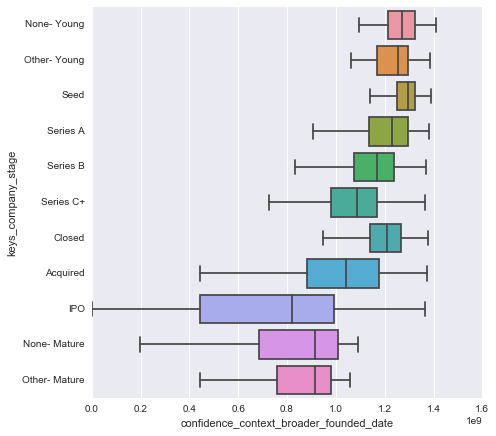

In [22]:
stages = ["None- Young", "Other- Young", "Seed", "Series A", "Series B", 
    "Series C+", "Closed", "Acquired", "IPO","None- Mature", "Other- Mature"]

f, ax = plt.subplots(figsize=(7, 7))

sns.boxplot(
    y="keys_company_stage", order=stages,
    x="confidence_context_broader_founded_date", 
    ax=ax, data=df, fliersize=0)

In [81]:
#constraints
df = df.loc[df['confidence_performance_other_operating_bool'] == 1]

df["outcome_funding_more_rounds_number"] = df["outcome_funding_rounds_number"] - df["confidence_validation_funding_rounds_number"]
df["outcome_funding_more_rounds_bool"] = df["outcome_funding_more_rounds_number"].apply(lambda x: 1 if x > 0 else 0)
df = df.loc[df['outcome_funding_more_rounds_number'] >= 0]

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Exited x Stage_2013 (Stacked Bar Chart)

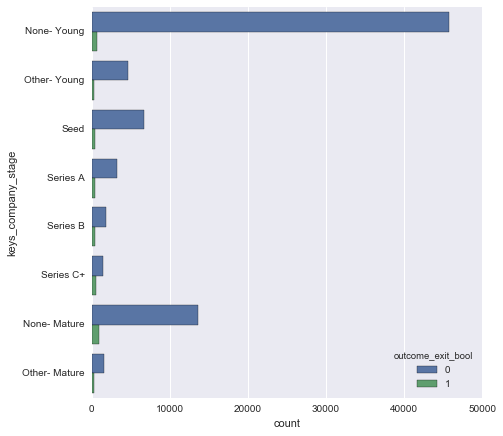

In [82]:
stages = ["None- Young", "Other- Young", 
        "Seed", "Series A", "Series B", "Series C+",
        "None- Mature", "Other- Mature"]

f, ax = plt.subplots(figsize=(7, 7))
sns.countplot(ax=ax, data=df,order=stages,
    y="keys_company_stage", hue="outcome_exit_bool")

### Raised x Stage_2013 (Stacked Bar Chart)

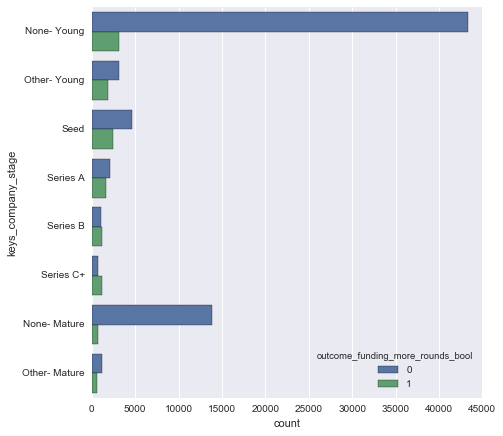

In [83]:
stages = ["None- Young", "Other- Young", 
        "Seed", "Series A", "Series B", "Series C+",
        "None- Mature", "Other- Mature"]

f, ax = plt.subplots(figsize=(7, 7))
sns.countplot(ax=ax, data=df,order=stages,
    y="keys_company_stage", hue="outcome_funding_more_rounds_bool")

In [85]:
#Create lifecycle stages - 2016
df["outcome_company_stage_series-a"] = df["outcome_raise_a_bool"]
df["outcome_company_stage_series-b"] = df["outcome_raise_b_bool"]
df["outcome_company_stage_series-c+"] = df["outcome_raise_cplus_bool"]
df["outcome_company_stage_ipo"] = df["outcome_ipo_bool"]
df["outcome_company_stage_acquired"] = df["outcome_acquired_bool"]
df["outcome_company_stage_closed"] = df["outcome_closed_bool"]

def label_stage(row):
    if row["outcome_company_stage_closed"] >= 1: stage = "Closed"
    elif row["outcome_company_stage_acquired"] >= 1: stage = "Acquired"
    elif row["outcome_company_stage_ipo"] >= 1: stage = "IPO"
    elif row["outcome_company_stage_series-c+"] >= 1: stage = "Series C+"
    elif row["outcome_company_stage_series-b"] >= 1: stage = "Series B"
    elif row["outcome_company_stage_series-a"] >= 1: stage = "Series A"
    elif row["outcome_funding_rounds_number"] == 0: stage = "None"
    else: stage = "Other"
    return stage

df["outcome_company_stage"] = df.apply(lambda row: label_stage(row), axis=1)
company_stage_2016 = df["outcome_company_stage"]

df_backup = df.copy()

### Stage_2016 x Stage_2013 (Cross Plot)
more exploration needed --> particularly for outcome variables, possibly even showing up issues with matching

In [103]:
company_stage_2016.value_counts()

None        129623
Other        21960
Acquired      5564
Series A      4272
Closed        2328
IPO           2179
Series B      1058
Name: outcome_company_stage, dtype: int64

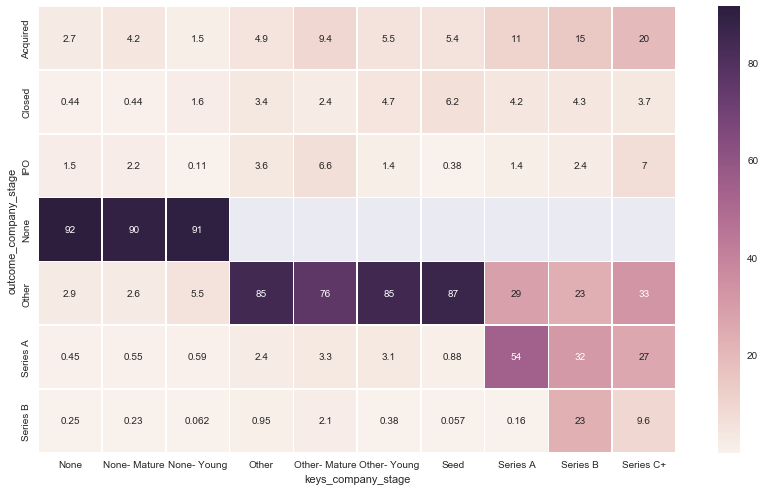

In [133]:
stages = df.groupby(["keys_company_stage", "outcome_company_stage"]).size().reset_index(name="Count")
stages_group = stages.groupby("keys_company_stage")["Count"].sum()
stages["Count"] = stages.apply(lambda x: x["Count"] / stages_group[x["keys_company_stage"]] * 100,axis=1)
stages = stages.pivot_table(columns= "keys_company_stage",index="outcome_company_stage", values="Count",
                            aggfunc=np.sum)
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(stages, annot=True, linewidths=.5, square=True)